
## University of Florida - Renewable Energy Conversion Laboratory
## Machine Learning Model of Solar Thermal Efficiency
### Chase Montgomery and Taylor Johnson 

In [21]:
#Libraries Needed
##############################################################################
import cantera as ct
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import datetime
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn import svm
import pickle
##############################################################################

In [22]:
##########################################################################################
#Solar Functions
#Radiation
def B(n):
    return (n-1)*360/365*np.pi/180
#Time correction Equation
def E(n):
    return 229.2*(0.000075+0.001868*np.cos(B(n))-0.032077*np.sin(B(n))-0.014615*np.cos(2*B(n))-0.04089*np.sin(2*B(n)))
#Declintion Angle
def delta(n):
    return 23.45*np.sin(360*(284+n)/365*np.pi/180)
#Rb - to relate normal beam radiation to tilted
def rb(lat,beta,declination,hour):
    return (np.cos((lat-beta)*np.pi/180)*np.cos(declination*np.pi/180)*np.cos(hour*np.pi/180) \
         +  np.sin((lat-beta)*np.pi/180)*np.sin(declination*np.pi/180)) / (np.cos(lat*np.pi/180)*np.cos(declination*np.pi/180)*\
            np.cos(hour*np.pi/180)+np.sin(lat*np.pi/180)*np.sin(declination*np.pi/180))
#Angle of Incidence
def theta(n,lat,beta,azimuth,hour): 
    return np.arccos(np.sin(delta(n)*np.pi/180)*np.sin(lat*np.pi/180)*np.cos(beta*np.pi/180)- \
                     np.sin(delta(n)*np.pi/180)*np.cos(lat*np.pi/180)*np.sin(beta*np.pi/180)*np.cos(azimuth*np.pi/180)+ \
                     np.cos(delta(n)*np.pi/180)*np.cos(lat*np.pi/180)*np.cos(beta*np.pi/180)*np.cos(hour*np.pi/180)+ \
                     np.cos(delta(n)*np.pi/180)*np.sin(lat*np.pi/180)*np.sin(beta*np.pi/180)*np.cos(azimuth*np.pi/180)*np.cos(hour*np.pi/180)+ \
                     np.cos(delta(n)*np.pi/180)*np.sin(beta*np.pi/180)*np.sin(azimuth*np.pi/180)*np.sin(hour*np.pi/180))
Gsc = 1367 #W m-2 
def Gon(n): 
    return Gsc*(1+0.033*np.cos(360*n/365*np.pi/180))  
#Daily 
def H_o(n,sunset_angle,lat,delta):
    return (Gon(n)*24*3600/np.pi)*( (np.cos(lat*np.pi/180)*np.cos(delta*np.pi/180)*np.sin(sunset_angle*np.pi/180))\
                                  +(np.sin(lat*np.pi/180)*np.sin(delta*np.pi/180)*sunset_angle*np.pi/180))
#Hourly 
def I_o(n,w1,w2,lat,delta):
    return (Gon(n)*12*3600/np.pi)*( (np.cos(lat*np.pi/180)*np.cos(delta*np.pi/180)*(np.sin(w2*np.pi/180)-np.sin(w1*np.pi/180)))\
                                  +(np.sin(lat*np.pi/180)*np.sin(delta*np.pi/180)*(w2-w1)*np.pi/180))
#Sunset Hour Angle
def sunset(lat,n):
    return np.arccos(-np.tan(lat*np.pi/180)*np.tan(delta(n)*np.pi/180))*180/np.pi
beta = 28 #tilt of XCPC
lat  = 29.6516 #Latitude of gainesville
long = 82.3248 #longitude of gainesville
Lst  = 75 #GMT-5

import warnings
warnings.filterwarnings("ignore")

In [23]:
# Read in Experimental Data
filepath = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\Consolidated_XCPC\ModelBase_4_10_2023.csv') #Where file is stored
data = pd.read_csv(filepath,engine='python') #Read csv
data.drop(columns=['T1','T3','T4','Incidence Angle','ZenDeg','AzDeg','Date','Time','Flow','Tilt'\
                   ,'Unnamed: 0','Unnamed: 0.1'],inplace = True) #Drop un-needed columns
data.rename(columns={"T2": "Temp"},inplace = True) #Only inlet temperature used, rename to Temperature

data = data[data.Efficiency > 0] #At start/end sometimes NaN,negative, etc. efficiencies, remove these 
data = data[data.Efficiency < 1]

#Time intervaling
t_int = 5 #Set interval to average
data = data.rolling(t_int,min_periods=0).mean() #Rolling average
ii = np.arange(0,len(data),t_int)
data = data.iloc[ii] #Take each 5 min average and condense
data.reset_index(inplace=True) #Reset index since we removed rows

In [24]:
################################################################
#Cloudy Day Model

# seperate out our x and y values
x_values = data[['GHI','DNI','DHI','Clearness','Temp']].values #Inputs to model
y_values = data['Efficiency'].values #Our output

#Modelling
#C- is regularization parameter, will control the fitting strength
#Kernel is the shape of the hyperplane fitted, 'rbf' is radial based function and I had the best luck with it
#Epsilon controls the error allowable in the algorithm
regr = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf',degree=3,C=1000.0, epsilon=0.025, gamma = 'scale'))
regr.fit(x_values, y_values)

#Store the results for later
with open('cloudy.joblib', 'wb') as pickle_file: 
    pickle.dump(regr, pickle_file)

#Coefficient of Determinace Plot 
y_pred_cloudy = regr.predict(x_values) #Predicted Efficiency
regress_cloudy = scipy.stats.linregress(y_values,y_pred_cloudy) #Line of best fit

In [25]:
################################################################
#Clear Day Model

# seperate out our x and y values
x_values = data[['GHI','DNI','DHI','Clearness','Temp']].values
y_values = data['Efficiency'].values

#Modeling
#Essentially same, but different input controls to fit behavior of clear periods
regr = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf',degree=3,C=50.0, epsilon=0.025, gamma = 'scale'))
regr.fit(x_values, y_values)

#Store the results for later
with open('clear.joblib', 'wb') as pickle_file:
    pickle.dump(regr, pickle_file)

#Coefficient of Determinace Plot
y_pred_clear = regr.predict(x_values)
regress_clear = scipy.stats.linregress(y_values,y_pred_clear)

Text(0, 0.5, 'Modeled Efficiency (-)')

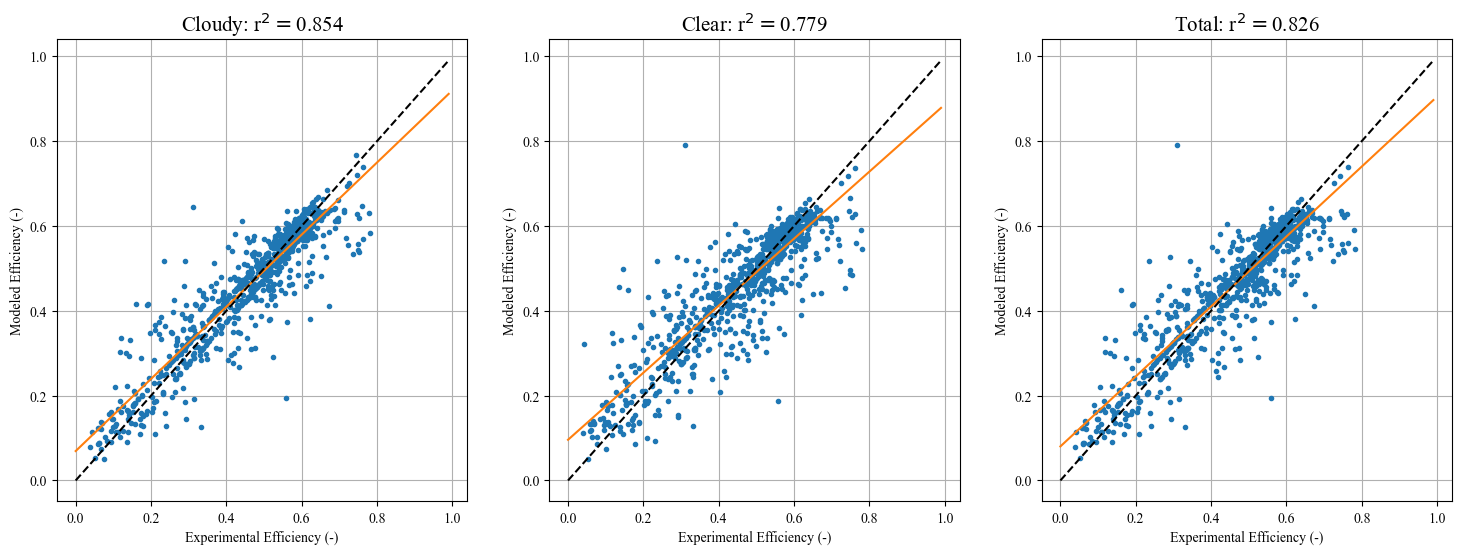

In [26]:
################################################################
#Performance of Combined Models
#This attempts to have an overall coefficient of determinancy based off appling each seperate model at different scenarios

y_pred_mixed = np.zeros(len(data))
interval = 2
for jj in np.arange(0,len(data)-1,2):
    dKtdt = abs(data['Clearness'][jj]-data['Clearness'][jj+1]) #See how large of a change in clearness occurs
    if data['Clearness'][jj]<0.7:  #If clearness is over 0.7 is probably sunny
        regr = pickle.load(open('cloudy.joblib', 'rb'))
    else:
        if dKtdt>0.3: #If change is over 0.3, probably means a cloud is startign to cover/uncover
            regr = pickle.load(open('cloudy.joblib', 'rb'))
        else:
            regr = pickle.load(open('clear.joblib', 'rb'))
            
    x_values = data[['GHI','DNI','DHI','Clearness','Temp']].values        #x values for prediction
    y_pred_mixed[jj:jj+interval] = regr.predict(x_values[jj:jj+interval]) #predict efficiency

#Coefficient of Determinace
y_values = data['Efficiency'].values
regress_mixed = scipy.stats.linregress(y_values,y_pred_mixed)
################################################################
#Coefficient of Determinace Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (18, 6))
z = np.arange(0,1,0.01)

ax1.plot(y_values,y_pred_cloudy,'.')
ax1.plot(z,regress_cloudy.intercept+ regress_cloudy.slope*z)
ax1.plot(z,1*z,'k--')
ax1.grid()
ax1.set_title('Cloudy: r$^2=$'+str(np.round(regress_cloudy.rvalue**2,3)), fontsize=15);
ax1.set_xlabel('Experimental Efficiency (-)')
ax1.set_ylabel('Modeled Efficiency (-)')

ax2.plot(y_values,y_pred_clear,'.')
ax2.plot(z,regress_clear.intercept+ regress_clear.slope*z)
ax2.plot(z,1*z,'k--')
ax2.grid()
ax2.set_title('Clear: r$^2=$'+str(np.round(regress_clear.rvalue**2,3)), fontsize=15);
ax2.set_xlabel('Experimental Efficiency (-)')
ax2.set_ylabel('Modeled Efficiency (-)')

ax3.plot(y_values,y_pred_mixed,'.')
ax3.plot(z,regress_mixed.intercept+ regress_mixed.slope*z)
ax3.plot(z,1*z,'k--')
ax3.grid()
ax3.set_title('Total: r$^2=$'+str(np.round(regress_mixed.rvalue**2,3)), fontsize=15);
ax3.set_xlabel('Experimental Efficiency (-)')
ax3.set_ylabel('Modeled Efficiency (-)')

In [27]:
##################################################################################################
#Applying Model to a Experiment

#Read in data - Here's where youd input the data from an experiment you want to compare

#Sharp intermittent
#file = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\Consolidated_XCPC\2023-02-23_Total.csv')

#Partly Cloudy 
file = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\Consolidated_XCPC\2023-02-02_Total.csv')

#Clear day
#file = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\Consolidated_XCPC\2023-01-17_Total.csv')


##################################################################################################
#Reading In Data
experiment = pd.read_csv(file,engine='python') #Read csv
n = (pd.to_datetime(experiment['Date'][0],format = '%Y-%m-%d')).dayofyear #Number of day of year (used in solar calcs)
experiment.rename(columns={"CMP10_GHI_Avg": "GHI", "CMP10_DHI_Avg": "DHI", "CHP1_DNI_Avg": "DNI","T2":"Temp"},inplace =True) 
experiment = experiment[experiment.Efficiency > 0] #Just as before, take out efficiencys that have no physical meaning
experiment = experiment[experiment.Efficiency < 1]
experiment['Time'] = pd.to_datetime(experiment['Time'], format='%H:%M:%S').dt.time

#Just as before, this allows to edit time interval of experiment
#Time intervaling
#I've had best performance with 3 minute intervals
t_int          = 3 #Set interval to average
experiment_avg = experiment.rolling(t_int,min_periods=0).mean() #Rolling average
ii             = np.arange(0,len(experiment),t_int)
experiment_avg = experiment_avg.iloc[ii] 
experiment_avg['Time'] = experiment['Time'].iloc[ii]
experiment     = experiment_avg
experiment.reset_index(inplace=True)

##################################################################################################
#Find Solar Time
#experiment['Time'] = pd.to_datetime(experiment['Time'],format = ' %H:%M:%S').dt.time
solar_t = np.zeros(len(experiment)) #Initialize solar time
hour =  np.zeros(len(experiment)) #Initialize hour angle
for jj in range(0,len(experiment),1):
    solar_t[jj] = experiment['Time'][jj].hour + experiment['Time'][jj].minute/60  + 4*(Lst - long)/60 + E(n)/60  #SolarTime
    hour[jj] = (solar_t[jj]-12)*15 #Hour angle
##################################################################################################   
#Finally, model efficiency!

#Flow Parameters and Initialization
flow  = 0.8 *0.00378541/60 #We assume flow is 0.8 gpm
Cp    = 4180 #Assume constant specific heat
rho   = 997 #Assume constant density
Tg    = np.zeros(np.size(experiment['GHI'])+1) #Initialize vector for temperature guess
Tg[0] = experiment['Temp'][0] #Assume starts at general ambient temperature
sigma = (5.6704e-8) #Stefan boltzmann constant
AL    = 400 #Convective and Radiative Loss Area
eta_temp = np.zeros(np.size(experiment['Time']))

for jj in np.arange(0,np.size(experiment['Time'])-1,1):
    dKtdt = abs(experiment['Clearness'][jj]-experiment['Clearness'][jj+1])
    Loss = AL* ( 0.3*sigma*(Tg[jj]**4-Tg[0]**4) + 0.01*(Tg[jj]-Tg[0])) / (rho*flow*Cp)
    Tg[jj+1] = Tg[jj] + (eta_temp[jj])*experiment['Tilt'][jj]*2.4/(rho*flow*Cp) - Loss
    if experiment['Clearness'][jj]<0.7: #If clearness is over 0,7 its probably sunny
        regr = pickle.load(open('cloudy.joblib', 'rb'))
    else:
        if dKtdt>0.4: #If clearness changes over 0.4, a cloud is starting to cover/uncover
            regr = pickle.load(open('cloudy.joblib', 'rb'))
        else:
            regr = pickle.load(open('clear.joblib', 'rb'))
    x_values = experiment[['GHI','DNI','DHI','Clearness','Temp']].values #x values for prediction
    x = x_values[jj].reshape(1, -1)
    eta_temp[jj+1] = regr.predict(x) #predict efficiency
    
#data_check['Temp'] = Tg[0:-1]   #COMMENT OUT FOR EXPERIMENTAL TEMP, UNCOMMENT FOR PREDICTED TEMP
    
eta = np.zeros(np.size(experiment['Time']))
interval = 2
for jj in np.arange(0,np.size(experiment['Time'])-1,2):
    #dKtdt = (KT_avg[jj]+KT_avg[jj+interval])/ (interval*2)
    dKtdt = abs(experiment['Clearness'][jj]-experiment['Clearness'][jj+1])

    if experiment['Clearness'][jj]<0.7:
        regr = pickle.load(open('cloudy.joblib', 'rb'))
    else:
        if dKtdt>0.4:
            regr = pickle.load(open('cloudy.joblib', 'rb'))
        else:
            regr = pickle.load(open('clear.joblib', 'rb'))
            
    x_values = experiment[['GHI','DNI','DHI','Clearness','Temp']].values #x values for prediction
    eta[jj:jj+interval] = regr.predict(x_values[jj:jj+interval]) #predict efficiency


#Mean sqare error
print('Mean Square Error:', round(mean_squared_error(experiment['Efficiency'], eta, squared=False)*100,2),'%')

#Integral Error
int_eta_model = scipy.integrate.trapz(eta,dx=1)
int_eta_exp   = scipy.integrate.trapz(experiment['Efficiency'],dx=1)
print('Energy Integral Error:',round(100*(int_eta_model-int_eta_exp )/int_eta_exp,2),'%' )

Mean Square Error: 10.0 %
Energy Integral Error: -3.78 %


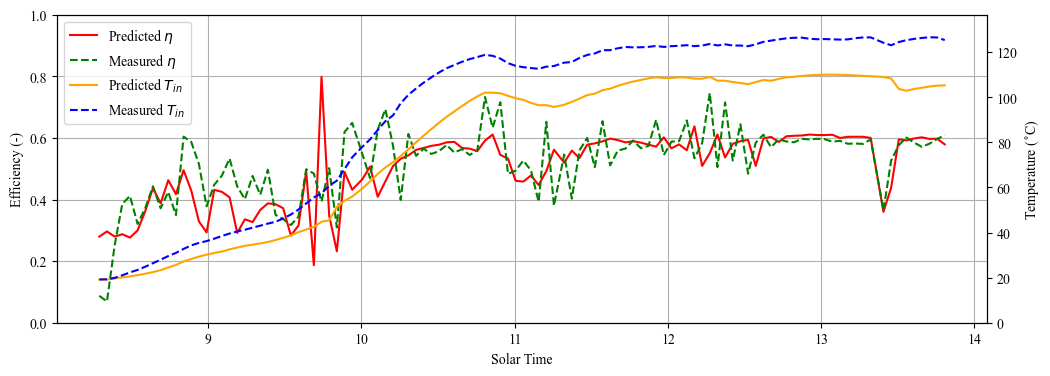

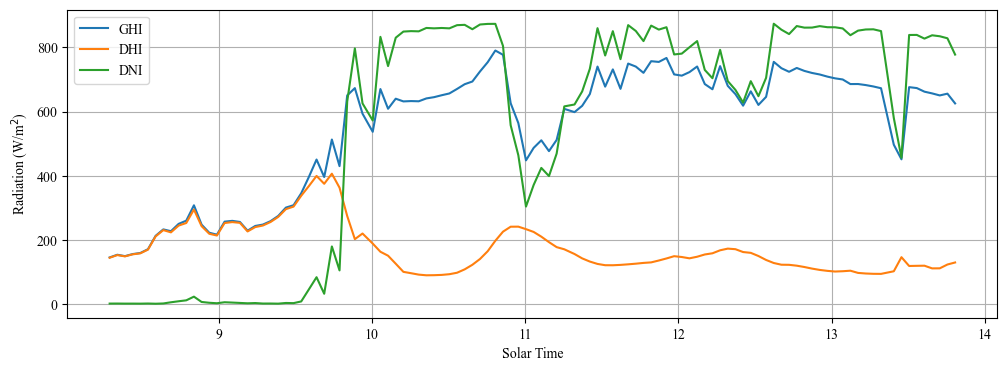

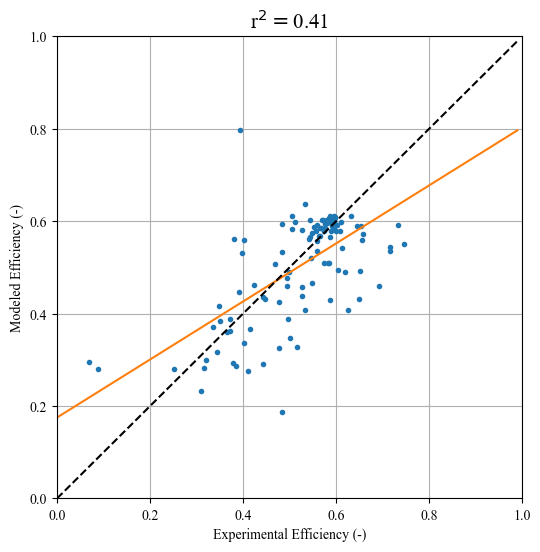

In [28]:
##################################################################################################
#Efficiency Plot
fig, ax1 = plt.subplots(figsize = (12, 4))
ax2 = ax1.twinx() 
plt.rcParams['figure.figsize'] = [12, 4]

ax1.plot(solar_t,eta,label='Predicted $\eta$',color="red")
ax1.plot(solar_t,experiment['Efficiency'],'--',label='Measured $\eta$',color="green")
ax1.set_ylim(0, 1)
ax1.set_xlabel("Solar Time")
ax1.set_ylabel('Efficiency (-)')  

ax2.plot(solar_t,Tg[:-1],label='Predicted $T_{in}$',color="orange")
ax2.plot(solar_t,experiment['Temp'],'--',label='Measured $T_{in}$',color="blue")
ax2.set_ylim(0, np.max(experiment['Temp'])+10)   
ax2.set_ylabel('Temperature ($^{\circ}$C)', color='k')
#Plot parameters
plt.rcParams["font.family"] = "Times New Roman"
pfont = {'fontname':'Times New Roman'}

ax1.grid()
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.show()

################################################################################################# 
#Radiation Plot 
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(solar_t,experiment['GHI'],label='GHI')
plt.plot(solar_t,experiment['DHI'],label='DHI')
plt.plot(solar_t,experiment['DNI'],label='DNI')

#Plot parameters
plt.rcParams["font.family"] = "Times New Roman"
pfont = {'fontname':'Times New Roman'}
plt.xlabel("Solar Time")
plt.ylabel("Radiation (W/m$^{2}$)")
plt.grid()
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
plt.legend()
plt.show()
########################################################################################## 
#Coefficient of Determinace
plt.rcParams['figure.figsize'] = [6, 6]
regress = scipy.stats.linregress(experiment['Efficiency'],eta)
z = np.arange(0,1,0.01)

plt.plot(experiment['Efficiency'],eta,'.')
plt.plot(z,regress.intercept+ regress.slope*z)
plt.plot(z,1*z,'k--')

#Plot
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams["font.family"] = "Times New Roman"
pfont = {'fontname':'Times New Roman'}
plt.xlabel("Experimental Efficiency (-)")
plt.ylabel("Modeled Efficiency (-)")

plt.grid()
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
#plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('r$^2=$'+str(np.round(regress.rvalue**2,3)), fontsize=15);
plt.show()
########################################################################################## 

In [16]:
#################################################################################################
#Applying to EXTENDED Solar Tracker Data

#If you understood examining an experiment's worth of data, now just imagining looping through that for every day
#using radiation and modelled tilted radiation from the solar tracker.

#Data - as an example I have here if you wanted to plot everyday in january

#january
solsys_filepath = (r'C:\Campbellsci\DevConfig\31931_Table1_2023-04-24T09-05.dat') #Solar tracker file from dates
start = '01-01-2023'  #Day to start
days = 30             #Number of days to simulate

start = pd.to_datetime(start,format = '%m-%d-%Y') 
datelist = pd.date_range(start, periods=days).tolist() #Create a list of days to iterate over

#Read File
solsys = pd.read_csv(solsys_filepath, sep=",",skiprows =[0])
solsys.drop([0,1],inplace = True) #Omit first 2 rows
solsys.rename(columns={"CMP10_GHI_Avg": "GHI", "CMP10_DHI_Avg": "DHI", "CHP1_DNI_Avg": "DNI","T2":"Temp"},inplace =True)
solsys['TIMESTAMP'] = pd.to_datetime(solsys['TIMESTAMP'])
solsys['Date']      = solsys['TIMESTAMP'].dt.date #Get just day,month,year
solsys['Date']      = pd.to_datetime(solsys['Date']) #Make sure is datetime dtype
solsys['Time']      = pd.to_datetime(solsys['TIMESTAMP']).dt.time #Get just hour,minute,second
solsys.reset_index(inplace=True) #Reset index to just include day/time of interest
avail_energy    = np.zeros(len(datelist)) #Initialize arrays for total energy each day
captured_energy = np.zeros(len(datelist))
clear           = np.zeros(len(datelist)) #Im not using these right now, but if wanted average clearness/efficiency
avg_eta         = np.zeros(len(datelist))
data = pd.DataFrame()

for kk in range(0,len(datelist),1): #Loop for each day
    day_of_interest = datelist[kk] 

    solar_tracker = solsys.loc[solsys['Date'] == day_of_interest] #Find rows of that day
    solar_tracker = solar_tracker[solar_tracker.GHI.astype('float') > 0] #At night, radiation is 'negative' (actually zero)
    solar_tracker = solar_tracker[solar_tracker.DHI.astype('float') > 0] #We dont care about this, so remove
    solar_tracker = solar_tracker[solar_tracker.DNI.astype('float') > 0]
    
    solar_tracker.reset_index(inplace=True) #Reset index to just include day/time of interest
    
    ##########################################################################################
    #Clearness Index Calculation
    day = solar_tracker['Date'][0]
    n   = solar_tracker['Date'][0].dayofyear #Day number out of 365
    declination = delta(n) #Declination angle

    hour    = np.zeros((np.size(solar_tracker['Date']),)) #Initialize hour angle
    solar_t = np.zeros((np.size(solar_tracker['Date']),)) #Initialize solar time
    for jj in range(0,len(solar_tracker['Date']),1): 
        solar_t[jj] = solar_tracker['Time'][jj].hour + solar_tracker['Time'][jj].minute/60  + 4*(Lst - long)/60 + E(n)/60 #SolarTime
        hour[jj] = (solar_t[jj]-12)*15 #Hour angle

    #Clearness Index, Kt
    kt =  np.zeros(len(solar_tracker['Date'])) #Initialize
    for ii in range(0,len(solar_tracker['Date'])-1,1):
        w1 = (solar_t[ii]-12)*15     #Convert to hour angle bounds of interest
        w2 = (solar_t[(ii+1)]-12)*15
        Io = I_o(n,w1,w2,lat,declination) #Extraterrestrial radiation energy
        I  = np.trapz(solar_tracker['GHI'][ii:(ii+2)].astype(float),dx=60) #Numerically integrate GHI data
        kt[ii] = I/Io
    kt[-1]=0
    solar_tracker['Clearness'] = kt
    solar_tracker['solar_t']   = solar_t
    ##########################################################################################
    #Model tilted radiation
    Gtot = (solar_tracker['GHI'].astype(float)-solar_tracker['DHI'].astype(float))*rb(lat,beta,declination,hour) + (1+np.cos(beta*np.pi/180))/2 * solar_tracker['DHI'].astype(float)
    solar_tracker['Tilt'] = Gtot
    ##########################################################################################
    #Time interval averaging
    t_int = 3 #Time interval
    solar_tracker_avg = solar_tracker.rolling(t_int,min_periods=0).mean() #Rolling average
    ii = np.arange(0,len(solar_tracker),t_int)
    solar_tracker_avg         = solar_tracker_avg.iloc[ii] 
    solar_tracker_avg['Time'] = solar_tracker['Time'].iloc[ii]
    solar_tracker_avg['Date'] = solar_tracker['Date'].iloc[ii]
    solar_tracker             = solar_tracker_avg
    solar_tracker['Temp']     = np.zeros(len(solar_tracker))
    solar_tracker.reset_index(drop=True,inplace=True)
    ##########################################################################################
    # Applying Model
    #Flow Parameters and Initialization
    flow  = 0.8 *0.00378541/60 #We assume flow is 0.8 gpm
    Cp    = 4180 #Assume constant specific heat
    rho   = 997 #Assume constant density
    Tg    = np.zeros(np.size(solar_tracker['GHI'])+1) #Initialize vector for temperature guess
    Tg[0] = 28 #Assume starts at general ambient temperature
    sigma = (5.6704e-8) #Stefan boltzmann constant
    AL    = 400 #Convective and Radiative Loss Area
    eta   = np.zeros(np.size(solar_tracker['Time']))

    for jj in np.arange(0,len(solar_tracker)-1,1):
        dKtdt = abs(solar_tracker['Clearness'][jj]-solar_tracker['Clearness'][jj+1])
        Loss = AL* ( 0.3*sigma*(Tg[jj]**4-Tg[0]**4) + 0.01*(Tg[jj]-Tg[0])) / (rho*flow*Cp)
        if Tg[jj] < 40:
            if Loss > (eta[jj])*solar_tracker['Tilt'][jj]*2.4/(rho*flow*Cp):
                Tg[jj+1] = Tg[jj]
            else:
                Tg[jj+1] = Tg[jj] + (eta[jj])*solar_tracker['Tilt'][jj]*2.4/(rho*flow*Cp) - Loss
        else:
            Tg[jj+1] = Tg[jj] + (eta[jj])*solar_tracker['Tilt'][jj]*2.4/(rho*flow*Cp) - Loss
        #if np.isnan(Tg[jj+1]):
        #    Tg[jj+1] = Tg[jj]
        solar_tracker['Temp'][jj+1] = Tg[jj+1]
        if solar_tracker['Clearness'][jj]<0.7:
            regr = pickle.load(open('cloudy.joblib', 'rb'))
        else:
            if dKtdt>0.4:
                regr = pickle.load(open('cloudy.joblib', 'rb'))
            else:
                regr = pickle.load(open('clear.joblib', 'rb'))
        x_values = solar_tracker[['GHI','DNI','DHI','Clearness','Temp']].values #x values for prediction
        x = x_values[jj].reshape(1, -1)
        eta[jj+1] = regr.predict(x)        #predict efficiency
    solar_tracker['Efficiency'] = eta      #Store in dataframe
    data = pd.concat([data,solar_tracker]) #Add on results to yoru compiled dataframe
      
    captured_energy[kk] = scipy.integrate.trapz(eta*solar_tracker['Tilt'],dx=3)*60 #Integrate to find total energy
    avail_energy[kk]    = scipy.integrate.trapz(Gtot,dx=1) * 60                    #Integrate to find total energy

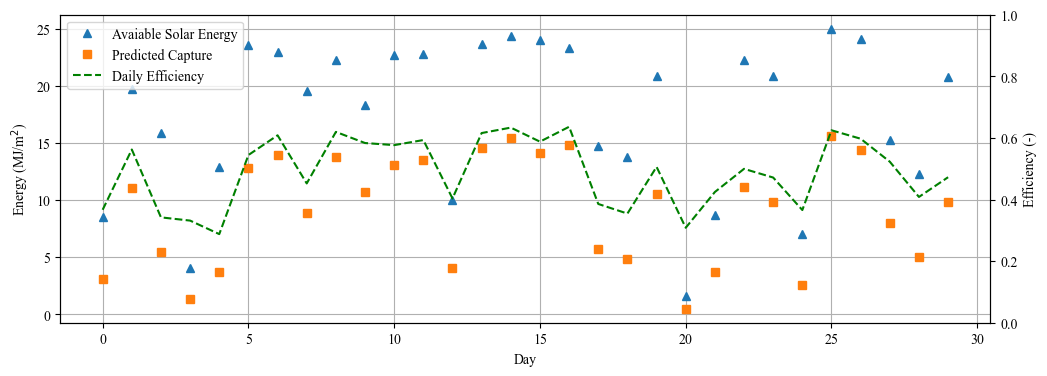

In [17]:
#Plot of Extended Performance
days = np.arange(0,len(datelist),1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  

ax1.plot(days,avail_energy/(10**6),   '^',label = 'Avaiable Solar Energy')
ax1.plot(days,captured_energy/(10**6),'s',label = 'Predicted Capture')
ax2.plot(days,captured_energy/avail_energy,'g--',label = 'Daily Efficiency')

ax1.set_xlabel("Day")
ax1.set_ylabel("Energy (MJ/m$^{2}$)")     
ax2.set_ylabel('Efficiency (-)', color='k')
ax2.set_ylim(0, 1)

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams["font.family"] = "Times New Roman"
pfont = {'fontname':'Times New Roman'}
ax1.grid() 
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.show()

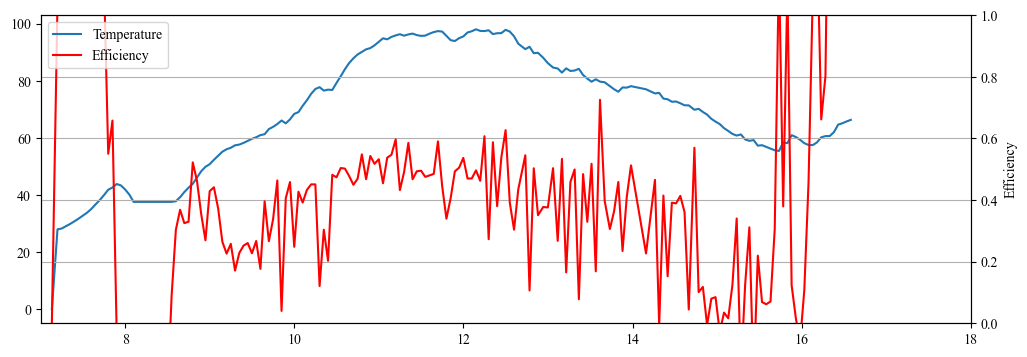

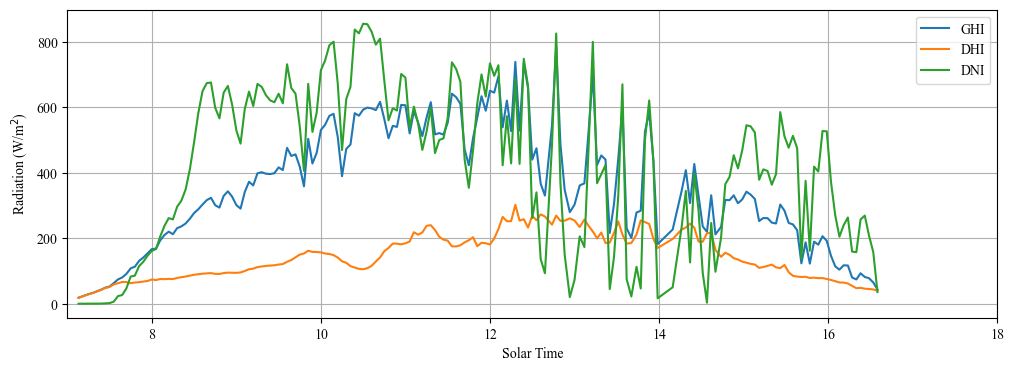

In [19]:
##################################################################################################
#Plotting Individual Days of the Set of Data
day_of_interest = '01-03-2023'
day_of_interest = pd.to_datetime(day_of_interest,format = '%m-%d-%Y') #Convert time to datetime dtype

solsys = data.loc[data['Date'] == day_of_interest] #Find rows of that day
solsys.reset_index(drop=True,inplace=True) #Reset index to just include day/time of interest
##################################################################################################
#Plot of Efficiency/Temp
fig, ax1 = plt.subplots(figsize = (12, 4))
ax2 = ax1.twinx()
ax2.plot(solsys['solar_t'],solsys['Efficiency'],label='Efficiency',color="red")
ax1.plot(solsys['solar_t'],solsys['Temp'],label='Temperature')

#Plot parameters
plt.rcParams["font.family"] = "Times New Roman"
pfont = {'fontname':'Times New Roman'}
plt.xlabel("Solar Time")
plt.ylabel("Efficiency")
plt.ylim(0,1)
plt.xlim(7,18)
plt.grid()
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.show()
################################################################################################# 
#Plot of Radiation
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(solsys['solar_t'],solsys['GHI'],label='GHI')
plt.plot(solsys['solar_t'],solsys['DHI'],label='DHI')
plt.plot(solsys['solar_t'],solsys['DNI'],label='DNI')

#Plot parameters
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams["font.family"] = "Times New Roman"
pfont = {'fontname':'Times New Roman'}
plt.xlabel("Solar Time")
plt.ylabel("Radiation (W/m$^{2}$)")
plt.grid()
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
plt.legend()
plt.xlim(7,18)
plt.show()
########################################################################################## 